In [4]:
%%capture
!pip install SentencePiece
!pip install -r rouge/requirements.txt
!pip install rouge-score

from pathlib import Path
import pandas as pd
import numpy as np
from datasets import Dataset
import seaborn as sns
from scipy import spatial
from rouge_score import rouge_scorer

sns.set_theme(font='Liberation Serif',
              rc={'figure.figsize': (7.5,3.75),
                  'font.size': 11,
                  'figure.dpi': 300,
                 })

## Load and prepare the dataframe

In [5]:
DATA = Path.cwd().parent / 'data'
SUMM_FOLDER = DATA / 'summaries_finetune'
TEXT_FILES = SUMM_FOLDER / 'text_files_copy'
SOURCE_TEXTS = SUMM_FOLDER / 'source_texts_clean'

In [6]:
summaries_df = pd.read_csv(SUMM_FOLDER / 'final_summaries_ai_aloe_fixed.csv', index_col=False)

In [7]:
df = summaries_df[['text', 'source', 'Main.Point', 'Details']]
ds = Dataset.from_pandas(df.reset_index(drop=True))
print(len(df))

4690


## Run the transformer

In [8]:
from transformers import AutoModel, AutoTokenizer, DataCollatorWithPadding
from transformers import LongformerTokenizer

import torch

seed = 42
model_name = "allenai/longformer-base-4096" #"google/bigbird-roberta-base"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModel.from_pretrained(model_name, output_hidden_states=True).to(DEVICE)
tokenizer = LongformerTokenizer.from_pretrained(model_name, use_fast=True)



Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
# Check the device
DEVICE

device(type='cuda')

### Run the transformer operation in cuda, then detach results and compare to make list of cos similarities

In [24]:
def getLastState(text):
    tokenized_text = tokenizer(text, return_tensors='pt').to(DEVICE)
    outputs = model(**tokenized_text)
    return outputs.last_hidden_state[0][0]

def getLongformerSimilarity(summary, source):
# cos_similarities = []
# counter = 0
# for row in df.iterrows():
#     print(counter, end='\r')
#     text = row[1]['text']
#     source = row[1]['source']
    text_embedding = getLastState(summary).cpu().detach().numpy()
    source_embedding = getLastState(source).cpu().detach().numpy()
    cos_similarity = 1 - spatial.distance.cosine(text_embedding, source_embedding)
    return cos_similarity
    # counter += 1
#df['longformer_cos'] = df.apply(lambda x: getLongformerSimilarity(x['text'], x['source']), axis=1)

### Attach the list to the dataframe

In [12]:
%%capture
from pathlib import Path
import pandas as pd
import numpy as np
from datasets import Dataset
import seaborn as sns
from scipy import spatial
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn import utils

In [13]:
DATA = Path.cwd().parent / 'data'
SUMM_FOLDER = DATA / 'summaries_finetune'
TEXT_FILES = SUMM_FOLDER / 'text_files_copy'
SOURCE_TEXTS = SUMM_FOLDER / 'source_texts_clean'

In [14]:
summaries_df = pd.read_csv(SUMM_FOLDER / 'final_summaries_ai_aloe_fixed.csv', index_col=False)

In [15]:
import nltk
from nltk.corpus import stopwords

def tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

def getDoc2vecSimilarity(df):
    cos_similarities = []
    text_tokenized = df['text'].apply(lambda t: tokenize_text(t)).to_frame()
    source_tokenized = df['source'].apply(lambda t: tokenize_text(t)).to_frame().rename(columns={'source': 'text'})
    all_tokenized = pd.concat([text_tokenized, source_tokenized]).reset_index()
    all_tagged = all_tokenized.apply(lambda r: TaggedDocument(words=r['text'], tags='text'), axis=1)
    
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample=0)
    model_dbow.build_vocab([x for x in tqdm(all_tagged)])
    for epoch in range(30):
        model_dbow.train(utils.shuffle([x for x in tqdm(all_tagged.values)]), total_examples=len(all_tagged.values), epochs=1)
    for i in range(len(text_tokenized)):
        text_vector = model_dbow.infer_vector(text_tokenized.iloc[i]['text'])
        source_vector = model_dbow.infer_vector(source_tokenized.iloc[i]['text'])
        cos_similarities.append(1 - spatial.distance.cosine(text_vector, source_vector))
    df['doc2vec_cos'] = cos_similarities
    return df

## Get Rouge Scores

In [16]:
def getRougeScore(df):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    df['rouge_score'] = df.apply(lambda x: scorer.score(x['text'], x['source'])['rougeL'].fmeasure, axis=1)
    return df

## Examine the results

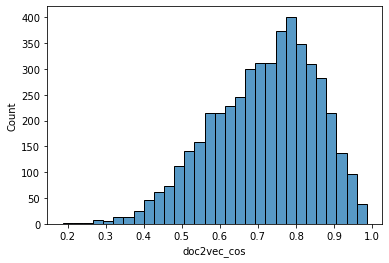

In [114]:
from matplotlib import pyplot as plt
sns.histplot(data = df, x='doc2vec_cos', bins=30)
plt.show()

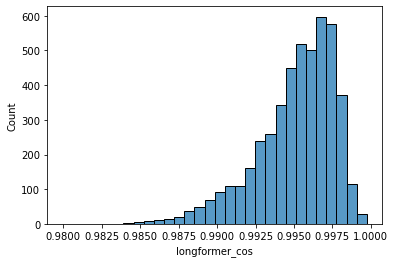

In [140]:
from matplotlib import pyplot as plt
sns.histplot(data = df, x='cos_similarity', bins=30)
plt.xlabel('longformer_cos')
plt.show()

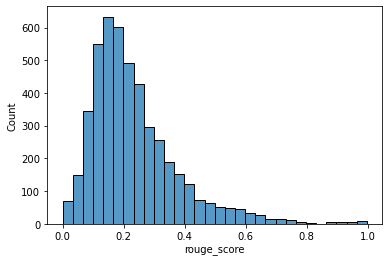

In [135]:
from matplotlib import pyplot as plt
sns.histplot(data = df, x='rouge_score', bins=30)
plt.show()

In [139]:
df[['Main.Point', 'Details', 'num_words', 'doc2vec_cos', 'cos_similarity', 'rouge_score']].corr()

,Main.Point,Details,num_words,doc2vec_cos,cos_similarity,rouge_score
Main.Point,1.000000,0.740816,0.215992,0.309451,0.390716,0.212663
Details,0.740816,1.000000,0.344446,0.412377,0.426577,0.302583
num_words,0.215992,0.344446,1.000000,0.350916,0.347158,0.671450
doc2vec_cos,0.309451,0.412377,0.350916,1.000000,0.401170,0.696127
cos_similarity,0.390716,0.426577,0.347158,0.401170,1.000000,0.403195
rouge_score,0.212663,0.302583,0.671450,0.696127,0.403195,1.000000


In [98]:
df[['doc2vec_cos', 'Details']].corr()

,doc2vec_cos,Details
doc2vec_cos,1.000000,0.412377
Details,0.412377,1.000000


## Run Experiment
This will divide the data into two sets, one where the source is shuffled. We will run the three similarity measures, and see which one does the best

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time

# split the data
original_df = summaries_df[['text', 'source']]
off_topic, on_topic = train_test_split(original_df, test_size = 0.5)
print(len(off_topic), len(on_topic))

2345 2345


In [18]:
# shuffle the sources in the off topic condition
off_topic['source'] = np.random.permutation(off_topic['source'].values)

In [19]:
# label the two conditions and rejoin
off_topic['condition'] = 'off_topic'
on_topic['condition'] = 'on_topic'
df = pd.concat([off_topic, on_topic])

In [23]:
df

,text,source,condition
3745,America has changed in recent years there are ...,Adding aerobic exercise to your routine is an ...,off_topic
381,The summary is that Alzheimer's is a disease t...,Some children are sent to school with empty st...,off_topic
7,There are two types of skin cancer: basal-cell...,Ultraviolet radiation\n\nUltraviolet radiation...,off_topic
3269,People can seriously hurt themselves or others...,Source A\n \nHealth effects related to cell ph...,off_topic
4411,The CIVIL SERVICE is a place where all men and...,The Impact of El Nino\nDifferent parts of the ...,off_topic
...,...,...,...
3132,Smoking is a dangerous activity that has a hig...,"Smoking kills more Americans than AIDS, drug a...",on_topic
2049,Car inspections are useful for many reason. To...,\nSome cars do not run the way they should. Ba...,on_topic
2766,"Behind fire, floods are one of the most common...",Floods are second only to fire as the most com...,on_topic
238,It is esay to reduce the risk of developing sk...,American Cancer Society\n\n \n\nUV radiation a...,on_topic


In [25]:
beginning_time = time.time()
df['longformer_cos'] = df.apply(lambda x: getLongformerSimilarity(x['text'], x['source']), axis=1)
end_time = time.time()
duration = end_time - beginning_time

print('That took', duration, 'seconds')
print('Or', duration/len(df), 'seconds per essay on average.')

That took 200.68014907836914 seconds
Or 0.04278894436639001 seconds per essay on average.


In [27]:

# import nltk
# from nltk.corpus import stopwords

# def tagged_document(list_of_list_of_words):
#     for i, list_of_words in enumerate(list_of_list_of_words):
#         yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

# def tokenize_text(text):
#     tokens = []
#     for sent in nltk.sent_tokenize(text):
#         for word in nltk.word_tokenize(sent):
#             if len(word) < 2:
#                 continue
#             tokens.append(word.lower())
#     return tokens

# text_tokenized = df['text'].apply(lambda t: tokenize_text(t)).to_frame()
# source_tokenized = df['source'].apply(lambda t: tokenize_text(t)).to_frame().rename(columns={'source': 'text'})
# all_tokenized = pd.concat([text_tokenized, source_tokenized]).reset_index()


# all_tagged = all_tokenized.apply(lambda r: TaggedDocument(words=r['text'], tags='text'), axis=1)
# model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample=0)
# model_dbow.build_vocab([x for x in tqdm(all_tagged)])
# for epoch in range(30):
#     model_dbow.train(utils.shuffle([x for x in tqdm(all_tagged.values)]), total_examples=len(all_tagged.values), epochs=1)
# for i in range(len(text_tokenized)):
#     text_vector = model_dbow.infer_vector(text_tokenized.iloc[i]['text'])
#     source_vector = model_dbow.infer_vector(source_tokenized.iloc[i]['text'])
#     cos_similarities.append(1 - spatial.distance.cosine(text_vector, source_vector))
# # df['doc2vec_cos'] = cos_similarities
beginning_time = time.time()    
df = getDoc2vecSimilarity(df)
end_time = time.time()
duration = end_time - beginning_time
print('That took', duration, 'seconds')
print('Or', duration/len(df), 'seconds per essay on average.')

100%|██████████| 9380/9380 [00:00<00:00, 1458104.35it/s]


That took 236.5424563884735 seconds
Or 0.05043549176726514 seconds per essay on average.


In [29]:
beginning_time = time.time()
df = getRougeScore(df)
end_time = time.time()
duration = end_time - beginning_time
print('That took', duration, 'seconds')
print('Or', duration/len(df), 'seconds per essay on average.')

That took 44.58302426338196 seconds
Or 0.00950597532268272 seconds per essay on average.


In [38]:
#define samples
group1 = df[df['condition']=='off_topic']
group2 = df[df['condition']=='on_topic']

Ttest_indResult(statistic=-95.93909601380211, pvalue=0.0)


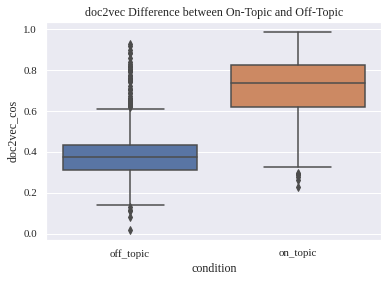

In [39]:
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind

print(ttest_ind(group1['doc2vec_cos'], group2['doc2vec_cos']))
sns.boxplot(data=df, y='doc2vec_cos', x='condition')
plt.title('doc2vec Difference between On-Topic and Off-Topic')
plt.show()

Ttest_indResult(statistic=-23.930470139950444, pvalue=1.6689310444243112e-119)


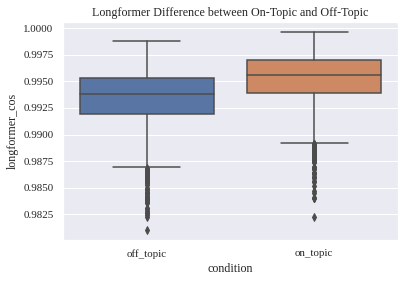

In [40]:

print(ttest_ind(group1['longformer_cos'], group2['longformer_cos']))
sns.boxplot(data=df, y='longformer_cos', x='condition')
plt.title('Longformer Difference between On-Topic and Off-Topic')
plt.show()

Ttest_indResult(statistic=-48.29168935523394, pvalue=0.0)


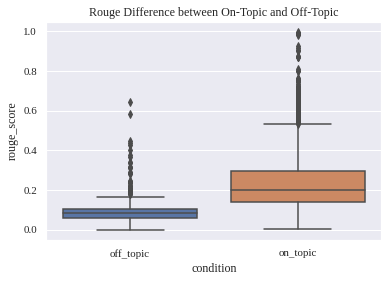

In [41]:
print(ttest_ind(group1['rouge_score'], group2['rouge_score']))
sns.boxplot(data=df, y='rouge_score', x='condition')
plt.title('Rouge Difference between On-Topic and Off-Topic')
plt.show()

In [42]:
len(df)

4690

In [83]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import MNLogit

In [70]:
train_df, test_df = train_test_split(df, test_size = 0.15)

## Rouge Score

In [82]:
train_x = train_df['rouge_score'].to_numpy().reshape(-1,1)
train_y = train_df['condition']
test_x = test_df['rouge_score'].to_numpy().reshape(-1,1)
test_y = test_df['condition']

log_reg = LogisticRegression()
log_reg.fit(train_x, train_y)
y_pred = log_reg.predict(test_x)

In [84]:
print('Accuracy: {:.2f}'.format(accuracy_score(test_y, y_pred)))
print('Error rate: {:.2f}'.format(1 - accuracy_score(test_y, y_pred)))

Accuracy: 0.87
Error rate: 0.13


In [91]:
train_x = train_df['doc2vec_cos'].to_numpy().reshape(-1,1)
train_y = train_df['condition']
test_x = test_df['doc2vec_cos'].to_numpy().reshape(-1,1)
test_y = test_df['condition']

log_reg = LogisticRegression()
log_reg.fit(train_x, train_y)
y_pred = log_reg.predict(test_x)

print('Accuracy: {:.2f}'.format(accuracy_score(test_y, y_pred)))
print('Error rate: {:.2f}'.format(1 - accuracy_score(test_y, y_pred)))

Accuracy: 0.92
Error rate: 0.08


In [92]:
train_x = train_df['longformer_cos'].to_numpy().reshape(-1,1)
train_y = train_df['condition']
test_x = test_df['longformer_cos'].to_numpy().reshape(-1,1)
test_y = test_df['condition']

log_reg = LogisticRegression()
log_reg.fit(train_x, train_y)
y_pred = log_reg.predict(test_x)

print('Accuracy: {:.2f}'.format(accuracy_score(test_y, y_pred)))
print('Error rate: {:.2f}'.format(1 - accuracy_score(test_y, y_pred)))

Accuracy: 0.48
Error rate: 0.52
